## Figure 7

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp
import datetime
import scipy.stats as stats

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import PlotFit, PlotData, LoadFit, compute_confidenceInterval_prediction

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [2]:
# Data and solver configurations
cellLine = "OVCAR3"
n_bootstraps = 250 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}

# Load Model 5
modelName = "CycleArrestModel_singleStep_extraDivs_dr"
modelDir = "./fits/"
currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)
treatmentModelBootstrapsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)

# Environment
nProcesses = 4 # Number of cores to use for bootstrapping
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}
myColourPlatte = {'Ctrl':"#929591",'MTD':"#FF9409",'CT':"#FF9409", 'AT1':'#029386','AT2':sns.xkcd_rgb["dark pink"]}
plottingOrder = ['Ctrl','MTD','AT1','AT2']

## d) Comparing fixed modulation and skipping in their ability to reduce cumulative dose

In [3]:
n0 = 5
fA = 0
t_end = 180 # simulation time length (in days)
fitObj, model = LoadFit(modelName, fitDir=currOutDir)
DMax = 100 #model.paramDic['DMax']

# Long-term intermittent tx needs tighter error bounds
solver_kws_tmp = solver_kws.copy()
solver_kws_tmp['absErr'] = 1e-12
solver_kws_tmp['relErr'] = 1e-12
solver_kws_tmp['max_step'] = 1.

### Plot heatmap of cumulative dose reduction vs treatment strategy

In [6]:
reductionFactorList = np.arange(0, 1, 0.05)
# n_breaksList = [0, 1, 2, 3]
n_breaksList = [0, 5, 10, 25]

tmpDicList = []
tmpDfList = []
for reductionFactor, n_breaks in tqdm(list(product(reductionFactorList, n_breaksList))):
    # Generate treatment schedule
    # We will spend a total proportion of reductionFactor amount of time off treatment.
    # These breaks will be equally distributed across n_breaks.
    if n_breaks > 0 and reductionFactor > 0:
        total_time_off_treatment = t_end * reductionFactor
        total_time_on_treatment = t_end - total_time_off_treatment
        length_break = total_time_off_treatment/n_breaks
        length_treatment = total_time_on_treatment/n_breaks
        # Generate treatment schedule
        currTime = 0
        treatmentSchedule = []
        for n in range(n_breaks):
            treatmentSchedule += [[currTime, currTime+length_treatment, DMax], 
                                  [currTime+length_treatment, currTime+length_treatment+length_break, 0]]
            currTime = currTime + length_treatment + length_break        
    else: # If no breaks, simulate reducing the dose throughout
        treatmentSchedule = [[0, t_end, DMax*(1-reductionFactor)]]

    # Simulate
#     print(treatmentSchedule)
    tmpDf, trajectoriesDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                 bootstrapResultsDf=treatmentModelBootstrapsDf[:1], # Only interested in MLE prediction
                                                 treatmentScheduleList=treatmentSchedule,
                                                 initialConditionsList={"P0":(1-fA)*n0, "A0":fA*n0},
                                                 returnTrajectories=True,
                                                 show_progress=False, n_time_steps=100,
                                                 alpha=ci_significanceLevel,
                                                 solver_kws=solver_kws_tmp)
    tmpDf['nBreaks'] = n_breaks
    tmpDf['reductionFactor'] = reductionFactor
    tmpDfList.append(tmpDf)

    # Quantify the fraction of simulation in which we achieved disease control (SD, PR, or CR)
    final_size = tmpDf.loc[(tmpDf.Variable=="TumourSize"), 'Estimate_MLE'].iloc[-1]
    fraction_progressed = np.mean(trajectoriesDf[:, -1, 0] > 1.2*n0)
    tmpDicList.append({"nBreaks":n_breaks, 
                       "reductionFactor":np.round(reductionFactor, 2),
                       "FinalSize":final_size,
                       "FinalSize_relative":final_size/n0,
                       "FractionProgressed":fraction_progressed, 
                       "FractionControlled":1-fraction_progressed})
modelPredictionsDf = pd.concat(tmpDfList)
summaryDf = pd.DataFrame(tmpDicList)
summaryDf.to_csv("./data/sweep_mod_vs_skipping.csv")

100%|███████████████████████████████████████████| 80/80 [00:18<00:00,  4.30it/s]


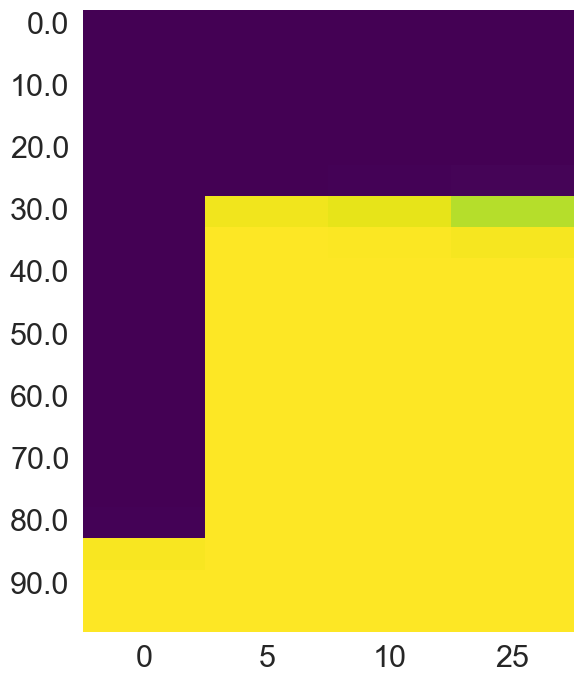

In [7]:
# Load data
summaryDf = pd.read_csv("./data/sweep_mod_vs_skipping.csv")
summaryDf['reductionFactor'] *= 100

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6,7))
df_melted = summaryDf.pivot(index="reductionFactor", columns="nBreaks", values="FinalSize_relative")

sns.heatmap(df_melted, cmap="viridis", cbar=False, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("./figures/modulation_vs_skipping_heatmap.pdf")

### Plot example simulations

In [8]:
# Parameters
reductionFactorList = [0.1, 0.5]
# n_breaksList = [0, 3]
n_breaksList_toShow = [0, 10]

In [9]:
tmpDicList = []
tmpDfList = []
for n_breaks, reductionFactor in tqdm(list(product(n_breaksList_toShow, reductionFactorList))):
    # Generate treatment schedule
    # We will spend a total proportion of reductionFactor amount of time off treatment.
    # These breaks will be equally distributed across n_breaks.
    if n_breaks > 0:
        total_time_off_treatment = t_end * reductionFactor
        total_time_on_treatment = t_end - total_time_off_treatment
        length_break = total_time_off_treatment/n_breaks
        length_treatment = total_time_on_treatment/n_breaks
        # Generate treatment schedule
        currTime = 0
        treatmentSchedule = []
        for n in range(n_breaks):
            treatmentSchedule += [[currTime, currTime+length_treatment, DMax], 
                                  [currTime+length_treatment, currTime+length_treatment+length_break, 0]]
            currTime = currTime + length_treatment + length_break        
    else: # If no breaks, simulate reducing the dose throughout
        treatmentSchedule = [[0, t_end, DMax*(1-reductionFactor)]]

    # Simulate
#     print(treatmentSchedule)
    tmpDf, trajectoriesDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                 bootstrapResultsDf=treatmentModelBootstrapsDf[:n_bootstraps],
                                                 treatmentScheduleList=treatmentSchedule,
                                                 initialConditionsList={"P0":(1-fA)*n0, "A0":fA*n0},
                                                 returnTrajectories=True,
                                                 show_progress=False, n_time_steps=100,
                                                 alpha=ci_significanceLevel,
                                                 solver_kws=solver_kws_tmp)
    tmpDf['nBreaks'] = n_breaks
    tmpDf['ReductionFactor'] = reductionFactor
    tmpDfList.append(tmpDf)

    # Quantify the fraction of simulation in which we achieved disease control (SD, PR, or CR)
    final_size = tmpDf.loc[(tmpDf.Variable=="TumourSize"), 'Estimate_MLE'].iloc[-1]
    fraction_progressed = np.mean(trajectoriesDf[:, -1, 0] > 1.2*n0)
    tmpDicList.append({"reductionFactor":reductionFactor, 
                       "nBreaks":n_breaks, 
                       "FinalSize":final_size,
                       "FinalSize_relative":final_size/n0,
                       "FractionProgressed":fraction_progressed, 
                       "FractionControlled":1-fraction_progressed})
modelPredictionsDf = pd.concat(tmpDfList)
summaryDf = pd.DataFrame(tmpDicList)

100%|█████████████████████████████████████████████| 4/4 [01:20<00:00, 20.12s/it]


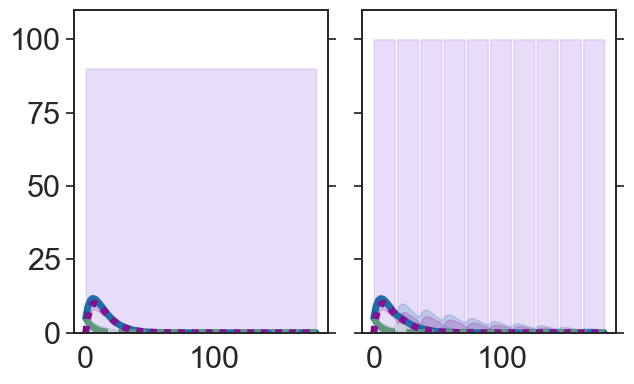

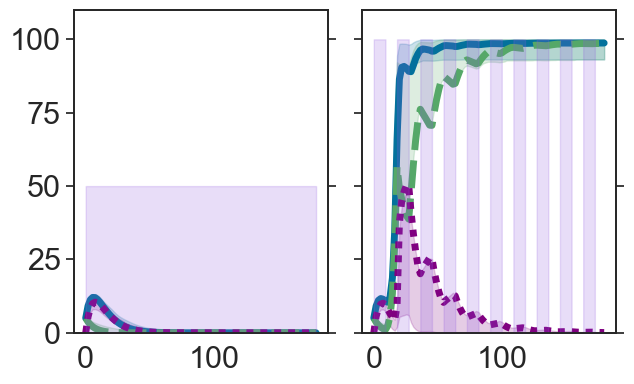

In [10]:
# fig,axList = plt.subplots(1,1,figsize=(8,6))
for reductionFactor in reductionFactorList:
    fig,axList = plt.subplots(1,len(n_breaksList_toShow),sharex=True,sharey=True,figsize=(6.5,4))
    for i, n_breaks in enumerate(n_breaksList_toShow):
        currModelDataDf = modelPredictionsDf[(modelPredictionsDf.nBreaks==n_breaks) &
                                             (modelPredictionsDf.ReductionFactor==reductionFactor)]
        # Plot
        ax = axList[i]
        # 1. Plot the model predictions and associated confidence intervals
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=cycleArrestModelPalette,
                     legend=False,
                     data=currModelDataDf, ax=ax)
        for var in cycleArrestModelPalette.keys():
            currDataDf = currModelDataDf[currModelDataDf.Variable==var]
            ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                             currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
        # 2. Plot the drug concentration for the simulation based on the MLE
        tmpDf = currModelDataDf.copy()
        tmpDf['Confluence'] = np.nan
        PlotData(tmpDf, y2lim=110, decorateY2=reductionFactor==1, ax=ax)
        ax.tick_params(labelsize=22)
        ax.set_ylim(0,110)
#         ax.set_title(n_breaks)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("./figures/mod_vs_skipping_sweep_%1.2freduction.pdf"%reductionFactor)

## b) Explain reason behind difference using the dose response curve

In [6]:
reductionFactorList = [0.1, 0.5]
n_breaksList_toShow = [0, 10]
dose_range = np.linspace(0,100,101) #35
paramDic = {x:fitObj.params.valuesdict()[x] for x in ["alpha", "EC50", "n"]}
t_end = 180 # simulation time length (in days)
fitObj, model = LoadFit(modelName, fitDir=currOutDir)
DMax = model.paramDic['DMax']

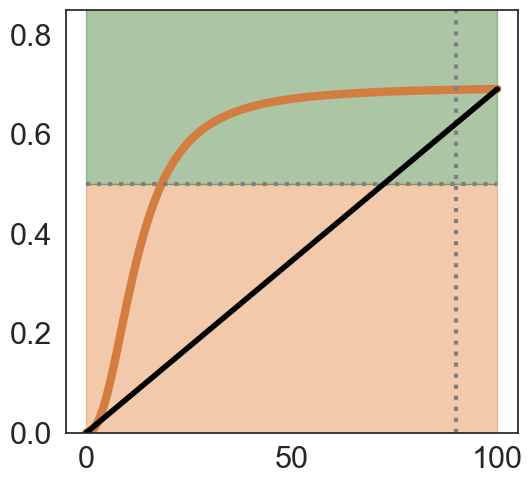

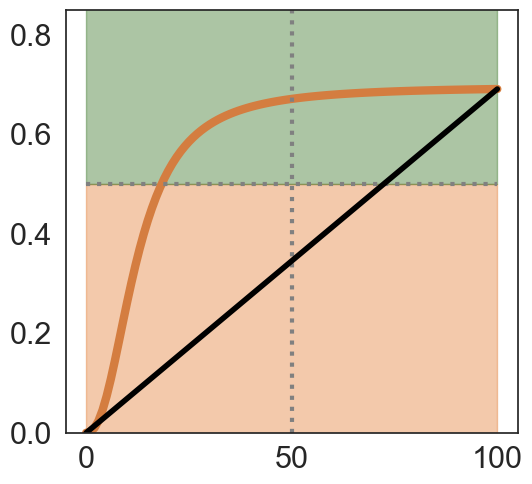

In [7]:
def dose_response(D, alpha=1, EC50=5, n=1):
    return alpha*np.power(D, n) / (np.power(EC50, n) + np.power(D, n))

dr_vals = dose_response(dose_range, **paramDic)
for reductionFactor in reductionFactorList:
    # Calculate average suppression during continuous and intermittent schedules
    tVec = np.linspace(0, t_end, 1000)
    tmpList = []
    for n_breaks in n_breaksList_toShow:
        # Generate treatment schedule
        # We will spend a total proportion of reductionFactor amount of time off treatment.
        # These breaks will be equally distributed across n_breaks.
        if n_breaks > 0 and reductionFactor > 0:
            total_time_off_treatment = t_end * reductionFactor
            total_time_on_treatment = t_end - total_time_off_treatment
            length_break = total_time_off_treatment/n_breaks
            length_treatment = total_time_on_treatment/n_breaks
            # Generate treatment schedule
            currTime = 0
            treatmentSchedule = []
            for n in range(n_breaks):
                treatmentSchedule += [[currTime, currTime+length_treatment, DMax], 
                                      [currTime+length_treatment, currTime+length_treatment+length_break, 0]]
                currTime = currTime + length_treatment + length_break        
        else: # If no breaks, simulate reducing the dose throughout
            treatmentSchedule = [[0, t_end, DMax*(1-reductionFactor)]]

        # Compute average dose and average effect
        treatmentSchedule_list = utils.TreatmentListToTS(treatmentSchedule, tVec=tVec)
        average_dose = np.mean(treatmentSchedule_list)
        average_effect = np.mean(dose_response(treatmentSchedule_list, **paramDic))
        tmpList.append({"n_breaks":n_breaks, "Dose":average_dose, "Effect":average_effect})
    effectDf = pd.DataFrame(tmpList)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(5.5,5))
    ax.plot(dose_range, dr_vals, linewidth=6, color="#D47D40")
#     sns.scatterplot(x="Dose", y="Effect", hue="n_breaks", s=120, legend=False, data=effectDf, ax=ax)
    ax.vlines(x=DMax*(1-reductionFactor), ymin=0, ymax=1, color="grey", linestyle=":", linewidth=3)
    ax.hlines(y=0.5, xmin=0, xmax=100, color="grey", linestyle=":", linewidth=3)
    ax.plot([0,100],[0,dose_response(100, **paramDic)], color="black", linewidth=4)
    ax.fill_between([0, 100], -10, 0.5, color='#E2792E', alpha=0.4)
    ax.fill_between([0, 100], 0.5, 10., color='#306F1D', alpha=0.4)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(0, 0.85) #0.8
    plt.tight_layout()
    plt.savefig("./figures/plateauArgument_reduction%1.2f.pdf"%reductionFactor)

### Calculate theoretical values for D* and D**

In [34]:
def D_star(alpha, EC50, n, DMax):
    # Dose up to which can use either flat reduction or skipping
    return (np.power(EC50,n) + np.power(DMax,n))/(2*alpha*np.power(DMax,n))*DMax

def D_min(alpha, EC50, n, DMax):
    # Maximum possible dose reduction
#     return np.power(-(1-2*alpha)*np.power(EC50,-n),1/n)
    return np.power(np.power(EC50,n)/(2*alpha-1),1/n)

In [35]:
# Ovcar3
print("D_star:", D_star(**paramDic, DMax=DMax))
print("D_min:", D_min(**paramDic, DMax=DMax))

D_star: 72.34263073862289
D_min: 18.353933115182326


In [38]:
# Ovcar4
fitObj_oc4, _ = LoadFit(modelName, fitDir=os.path.join(modelDir, "treatmentModel", "OVCAR4", modelName))
paramDic_oc4 = {x:fitObj_oc4.params.valuesdict()[x] for x in ["alpha", "EC50", "n"]}

print("D_star:", D_star(**paramDic_oc4, DMax=DMax))
print("D_min:", D_min(**paramDic_oc4, DMax=DMax))

D_star: 55.70938399689658
D_min: 9.122257473427132


### Validate them

In [29]:
# Parameters
reductionFactorList = [1-x for x in [0.73, 0.71, 0.19, 0.17]]
n_breaksList_toShow = [0, 10]

In [30]:
tmpDicList = []
tmpDfList = []
for n_breaks, reductionFactor in tqdm(list(product(n_breaksList_toShow, reductionFactorList))):
    # Generate treatment schedule
    # We will spend a total proportion of reductionFactor amount of time off treatment.
    # These breaks will be equally distributed across n_breaks.
    if n_breaks > 0:
        total_time_off_treatment = t_end * reductionFactor
        total_time_on_treatment = t_end - total_time_off_treatment
        length_break = total_time_off_treatment/n_breaks
        length_treatment = total_time_on_treatment/n_breaks
        # Generate treatment schedule
        currTime = 0
        treatmentSchedule = []
        for n in range(n_breaks):
            treatmentSchedule += [[currTime, currTime+length_treatment, DMax], 
                                  [currTime+length_treatment, currTime+length_treatment+length_break, 0]]
            currTime = currTime + length_treatment + length_break        
    else: # If no breaks, simulate reducing the dose throughout
        treatmentSchedule = [[0, t_end, DMax*(1-reductionFactor)]]

    # Simulate
#     print(treatmentSchedule)
    tmpDf, trajectoriesDf = compute_confidenceInterval_prediction(fitObj=fitObj, 
                                                 bootstrapResultsDf=treatmentModelBootstrapsDf[:1],
                                                 treatmentScheduleList=treatmentSchedule,
                                                 initialConditionsList={"P0":(1-fA)*n0, "A0":fA*n0},
                                                 returnTrajectories=True,
                                                 show_progress=False, n_time_steps=100,
                                                 alpha=ci_significanceLevel,
                                                 solver_kws=solver_kws_tmp)
    tmpDf['nBreaks'] = n_breaks
    tmpDf['ReductionFactor'] = reductionFactor
    tmpDfList.append(tmpDf)

    # Quantify the fraction of simulation in which we achieved disease control (SD, PR, or CR)
    final_size = tmpDf.loc[(tmpDf.Variable=="TumourSize"), 'Estimate_MLE'].iloc[-1]
    fraction_progressed = np.mean(trajectoriesDf[:, -1, 0] > 1.2*n0)
    tmpDicList.append({"reductionFactor":reductionFactor, 
                       "nBreaks":n_breaks, 
                       "FinalSize":final_size,
                       "FinalSize_relative":final_size/n0,
                       "FractionProgressed":fraction_progressed, 
                       "FractionControlled":1-fraction_progressed})
modelPredictionsDf = pd.concat(tmpDfList)
summaryDf = pd.DataFrame(tmpDicList)

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  4.69it/s]


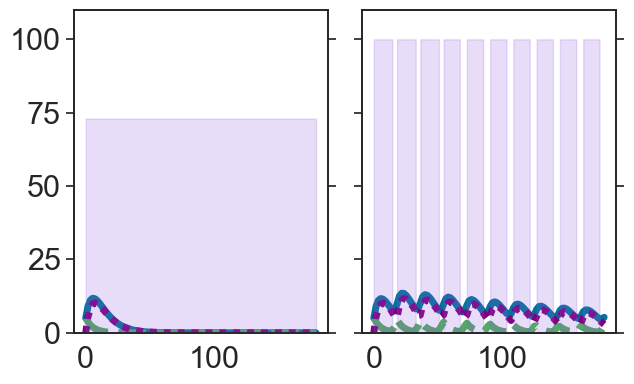

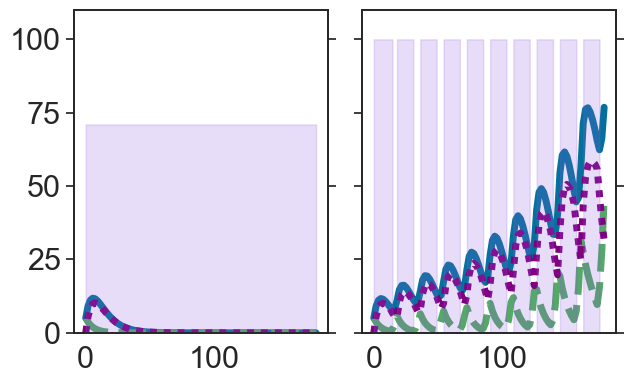

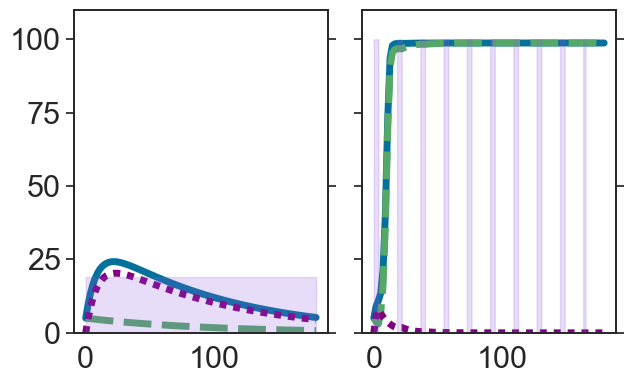

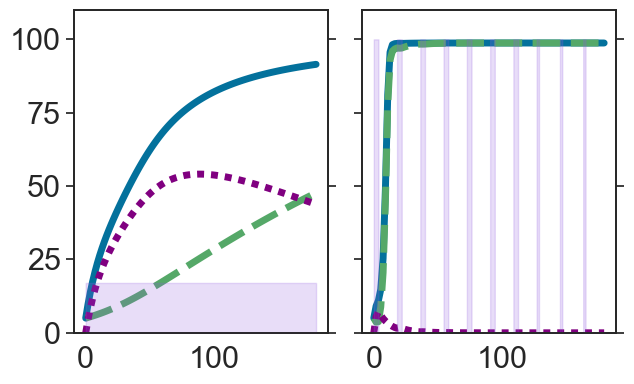

In [31]:
# fig,axList = plt.subplots(1,1,figsize=(8,6))
for reductionFactor in reductionFactorList:
    fig,axList = plt.subplots(1,len(n_breaksList_toShow),sharex=True,sharey=True,figsize=(6.5,4))
    for i, n_breaks in enumerate(n_breaksList_toShow):
        currModelDataDf = modelPredictionsDf[(modelPredictionsDf.nBreaks==n_breaks) &
                                             (modelPredictionsDf.ReductionFactor==reductionFactor)]
        # Plot
        ax = axList[i]
        # 1. Plot the model predictions and associated confidence intervals
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=cycleArrestModelPalette,
                     legend=False,
                     data=currModelDataDf, ax=ax)
#         for var in cycleArrestModelPalette.keys():
#             currDataDf = currModelDataDf[currModelDataDf.Variable==var]
#             ax.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
#                              currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
        # 2. Plot the drug concentration for the simulation based on the MLE
        tmpDf = currModelDataDf.copy()
        tmpDf['Confluence'] = np.nan
        PlotData(tmpDf, y2lim=110, decorateY2=reductionFactor==1, ax=ax)
        ax.tick_params(labelsize=22)
        ax.set_ylim(0,110)
#         ax.set_title(n_breaks)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout()
#     plt.savefig("./figures/mod_vs_skipping_sweep_%1.2freduction.pdf"%reductionFactor)

## c) Small changes in dose-response parameters can lead to significant variation in treatment response

In [134]:
n0 = 5
fA = 0
intervalLength = 30 # how frequently treatment is adjusted (in days)
t_end = 180 # simulation time length (in days)
fitObj, model = LoadFit(modelName, fitDir=currOutDir)

In [135]:
# Vary alpha
max_perturb = 0.1 # parameter sweep range
n_vals = 3
reductionFactor = 0.17 # Corresponds to G1, the first dose-reduction level for toxicity
DMax = 22 # Based on Matteo et al (2016), who report a CMax of 9.37ug/ml. Assuming a mol mass of Olaparib of 435.8g/mol, we get 21.5uM

# Algorithm
dose = (1-reductionFactor)*DMax
algorithmSpecsDic = {"CT_MTD":{'atThreshold':1., 'doseList':[DMax],
                           'D0':DMax, 'intervalLength':intervalLength, 
                           't_end':t_end},
                     "CT":{'atThreshold':1., 'doseList':[(1-reductionFactor)*DMax],
                           'D0':dose, 'intervalLength':intervalLength, 
                           't_end':t_end},
                     "AT1":{'atThreshold':0., 'doseList':list(np.array([400, 500, 600])/600*DMax),
                         'D0':DMax, 'intervalLength':intervalLength, 
                         't_end':t_end},                     
#                      "AT1_FT":{'atThreshold':0., 'doseList':list(np.array([400, 450, 500, 550, 600])/600*DMax),
#                          'D0':DMax, 'intervalLength':intervalLength, 
#                          't_end':t_end},                     
                    }

# Generate parameter grid
# perturbationsList = np.linspace(max_perturb, -max_perturb, n_vals)
perturbationsList = np.array([0, max_perturb, -max_perturb])
valList_alpha = (1+perturbationsList)*fitObj.params["alpha"].value

# Solver keywords
solver_kws_tmp = solver_kws.copy()
solver_kws_tmp['absErr'] = 1e-10
solver_kws_tmp['relErr'] = 1e-10
solver_kws_tmp['max_step'] = 1

# Simulate
tmpDfList = []
tmpDicList = []
for alpha in valList_alpha:
    for algorithm in algorithmSpecsDic.keys():
        fitObj_tmp, _  = LoadFit(modelName, fitDir=currOutDir)
        fitObj_tmp.params["alpha"].set(value=alpha)
        tmpDf, _ = compute_confidenceInterval_prediction(fitObj=fitObj_tmp, 
                                                     atToProfile="AT1", # works for simulating both AT1 and CT
                                                     at_kws=algorithmSpecsDic[algorithm],
                                                     initialConditionsList={"P0":(1-fA)*n0, "A0":fA*n0},
                                                     returnTrajectories=True,
                                                     show_progress=False, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws_tmp)
        tmpDf['Alpha'] = alpha
        tmpDf["Algorithm"] = algorithm
        tmpDfList.append(tmpDf)
        # Quantify the mean tumor burden and dose
        meanBurden = tmpDf[tmpDf.Variable=="TumourSize"].Estimate_MLE.mean()
        cumDrug = np.sum(tmpDf[tmpDf.Variable=="TumourSize"].DrugConcentration)
        tmpDicList.append({"Alpha":alpha, "Algorithm":algorithm,
                           "MeanBurden":meanBurden, 
                           "CumDrug":cumDrug,
                           "MeanDrug":cumDrug/tmpDf[tmpDf.Variable=="TumourSize"].shape[0]})
modelPredictionsDf = pd.concat(tmpDfList)
summaryDf = pd.DataFrame(tmpDicList)

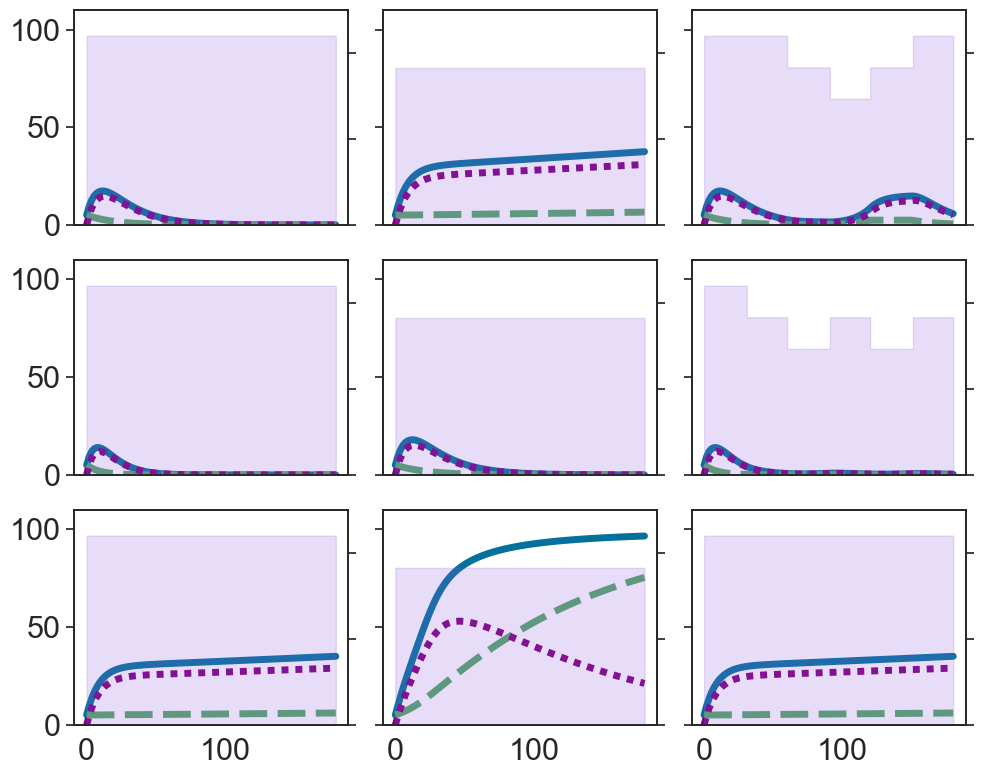

In [151]:
fig, axList = plt.subplots(len(valList_alpha),3,sharex=True,sharey=True,figsize=(10,8)) # 12
for j, algorithm in enumerate(algorithmSpecsDic.keys()):
    for i, alpha in enumerate(valList_alpha):
        currModelDataDf = modelPredictionsDf[(modelPredictionsDf.Algorithm==algorithm) &
                                             (modelPredictionsDf.Alpha==alpha)]
        # Plot
        ax = axList[i,j]
        # 1. Plot the model predictions and associated confidence intervals
        sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
                     lw=5, palette=cycleArrestModelPalette,
                     legend=False,
                     data=currModelDataDf, ax=ax)
        # 2. Plot the drug concentration for the simulation based on the MLE
        tmpDf = currModelDataDf.copy()
        tmpDf['Confluence'] = np.nan
        PlotData(tmpDf, y2lim=25, decorateY2=reductionFactor==1, ax=ax)
        ax.tick_params(labelsize=22)
        ax.set_ylim(0,110)
#         ax.set_title("%1.2f, %1.2f"%(alpha, n))
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax2 = ax.get_shared_x_axes().get_siblings(ax)[-1]
        ax2.tick_params(labelsize=22)
    # plt.tight_layout()
plt.savefig("./figures/txPrediction_de-escalation.pdf")

### Plot the associated dose-response curves

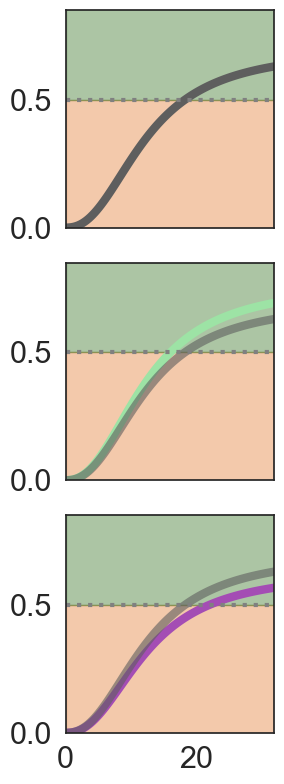

In [154]:
# Parameters
dose_range = np.linspace(0,DMax+10,101) #35
fitObj_tmp, _  = LoadFit(modelName, fitDir=currOutDir)
paramDic = {x:fitObj_tmp.params.valuesdict()[x] for x in ["EC50", "n"]}

def dose_response(D, alpha=1, EC50=5, n=1):
    return alpha*np.power(D, n) / (np.power(EC50, n) + np.power(D, n))

fig, axList = plt.subplots(3,1,sharex=True,sharey=True,figsize=(3,8)) #3.5
case_palette = {0:"#5E5E5E", 1:"#9DE3A5", 2:"#A44DB4"}
for i, alpha in enumerate(valList_alpha):
    # Compute the DRC
    paramDic["alpha"] = alpha
    dr_vals = dose_response(dose_range, **paramDic)
    if i==0:
        dr_baseline = dr_vals

    # Plot
#     fig, ax = plt.subplots(1, 1, figsize=(5.5,5))
    ax = axList.flatten()[i]
    ax.plot(dose_range, dr_vals, linewidth=6, color=case_palette[i])
    if i>0:
        ax.plot(dose_range, dr_baseline, linewidth=6, color=case_palette[0], alpha=0.6)
    ax.hlines(y=0.5, xmin=0, xmax=100, color="grey", linestyle=":", linewidth=3)
#     ax.plot([0,100],[0,dose_response(100, **paramDic)], color="black", linewidth=4)
    ax.fill_between([0, 100], -10, 0.5, color='#E2792E', alpha=0.4)
    ax.fill_between([0, 100], 0.5, 10., color='#306F1D', alpha=0.4)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(0, DMax+10)
    ax.set_ylim(0, 0.85) #0.8
    plt.tight_layout()
    plt.savefig("./figures/txPrediction_de-escalation_drugResponseCurves.pdf")

### Plot the drug use

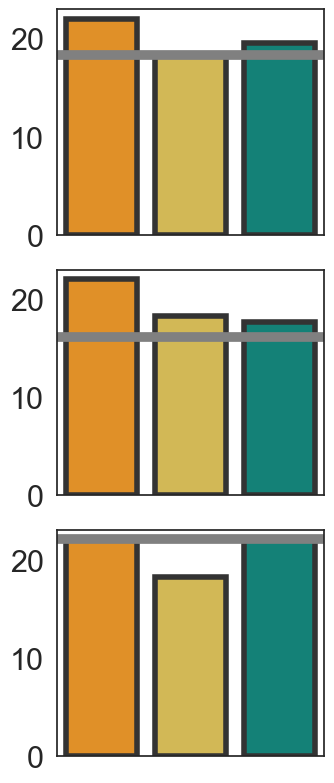

In [152]:
myColourPlatte = {'CT_MTD':"#FF9409",'CT':"#E6C442", #'Ctrl':"#929591",
                  'AT1':'#029386','AT1_FT':'#029386'}

def D_min(alpha, EC50, n, DMax):
    # Maximum possible dose reduction
    return np.power(np.power(EC50,n)/(2*alpha-1),1/n)

fig, axList = plt.subplots(3,1,sharex=True,sharey=True,figsize=(3.5,8))
for i,alpha in enumerate(valList_alpha):
#     plt.figure(figsize=(5,5)) #(7.5,6)
    ax = axList.flatten()[i]
    sns.barplot(x="Algorithm", y="MeanDrug", 
                 edgecolor=".2",linewidth=4,
                 errwidth=5, errcolor=sns.xkcd_rgb["charcoal grey"],
                 palette=myColourPlatte,
                 data=summaryDf[summaryDf['Alpha']==alpha], ax=ax)
    # Plot theoretical max reduction
    paramDic = {x:fitObj.params.valuesdict()[x] for x in ["EC50", "n"]}
    paramDic["alpha"] = alpha
    ax.hlines(y=D_min(**paramDic, DMax=DMax), 
              xmin=-1, xmax=4, color="grey", linestyle="-", linewidth=7)
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(0,23)
    ax.set_ylabel("")
    ax.set_xlabel(r"")
    ax.set_xticklabels([])
    # ax.set_yticklabels([0,2.5,5,7.5,10,12.5])
    # sns.despine(offset=5, trim=True)
#     ax.set_tick_params(labelsize=36)
plt.tight_layout()
# plt.savefig("figures/txPrediction_de-escalation_drugUse_alpha_%1.2f.pdf"%alpha)
plt.savefig("figures/txPrediction_de-escalation_drugUse.pdf")